In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image

In [3]:
# Image dimensions
img_height, img_width = 30, 40

In [4]:
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
    split = int(len(df) * 0.8)
    return df[:split], df[split:]

def load_images(dataframe, img_folder):
    X_data, Y_data = [], []
    for _, row in dataframe.iterrows():
        img_path = os.path.join(img_folder, row["image"])
        img = Image.open(img_path).convert("L").resize((img_width, img_height), Image.LANCZOS)
        X_data.append(np.array(img).flatten())  # Flatten image to (1200,)
        Y_data.append(row["label"])
    return np.array(X_data).T / 255.0, np.array(Y_data).reshape(1, -1)

In [40]:

def one_hot_encode(labels, num_classes):
    labels = np.array(labels, dtype=int)  # Ensure int type
    one_hot = np.zeros((num_classes, len(labels)))
    one_hot[labels, np.arange(len(labels))] = 1
    return one_hot


In [24]:
def initialize_parameters(input_size, num_classes):
    np.random.seed(42)
    W = np.random.randn(num_classes, input_size) * np.sqrt(2. / input_size)  # He
    b = np.zeros((num_classes, 1))
    return W, b

def softmax(Z):
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)  # Numerical stability
    exp_Z = np.exp(Z_shifted)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def compute_loss(A, Y):
    m = Y.shape[1]
    return -np.sum(Y * np.log(A + 1e-8)) / m  # Small epsilon to prevent log(0)


def forward_propagation(W, b, X, Y=None):  # Y is optional now
    Z = np.dot(W, X) + b
    A = softmax(Z)
    loss = compute_loss(A, Y) if Y is not None else None  # Compute loss only in training
    return A, loss, Z

def backward_propagation(A, Y, X):
    m = X.shape[1]
    dZ = A - Y
    dW = np.dot(dZ, X.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    return dW, db
    


In [7]:
def update_parameters_adam(W, b, dW, db, v_dW, v_db, s_dW, s_db, t, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    v_dW = beta1 * v_dW + (1 - beta1) * dW
    v_db = beta1 * v_db + (1 - beta1) * db
    s_dW = beta2 * s_dW + (1 - beta2) * (dW ** 2)
    s_db = beta2 * s_db + (1 - beta2) * (db ** 2)
    
    v_dW_corrected = v_dW / (1 - beta1 ** t)
    v_db_corrected = v_db / (1 - beta1 ** t)
    s_dW_corrected = s_dW / (1 - beta2 ** t)
    s_db_corrected = s_db / (1 - beta2 ** t)
    
    W -= lr * v_dW_corrected / (np.sqrt(s_dW_corrected) + epsilon)
    b -= lr * v_db_corrected / (np.sqrt(s_db_corrected) + epsilon)
    
    return W, b, v_dW, v_db, s_dW, s_db


In [8]:
def create_minibatches(X, Y, batch_size):
    num_samples = X.shape[1]
    indices = np.random.permutation(num_samples)
    X_shuffled, Y_shuffled = X[:, indices], Y[:, indices]
    minibatches = [(X_shuffled[:, i:i+batch_size], Y_shuffled[:, i:i+batch_size]) 
                   for i in range(0, num_samples, batch_size)]
    return minibatches


In [27]:
def train_model(X_train, Y_train, X_test, Y_test, input_size, num_classes, batch_size, epochs, lr=0.001):
    W, b = initialize_parameters(input_size, num_classes)
    v_dW, v_db, s_dW, s_db = np.zeros_like(W), np.zeros_like(b), np.zeros_like(W), np.zeros_like(b)
    t = 0

    for epoch in range(epochs):
        minibatches = create_minibatches(X_train, Y_train, batch_size)
        total_loss = 0

        for X_batch, Y_batch in minibatches:
            t += 1
            A, loss, _ = forward_propagation(W, b, X_batch, Y_batch)
            dW, db = backward_propagation(A, Y_batch, X_batch)
            W, b, v_dW, v_db, s_dW, s_db = update_parameters_adam(W, b, dW, db, v_dW, v_db, s_dW, s_db, t, lr)

            total_loss += loss

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(minibatches):.4f}")

    return W, b


In [18]:

def predict(W, b, X):
    A, _, _ = forward_propagation(W, b, X, None)
    return np.argmax(A, axis=0)

def compute_accuracy(W, b, X, Y):
    predictions = predict(W, b, X)
    true_labels = np.argmax(Y, axis=0)
    return np.mean(predictions == true_labels) * 100


In [11]:
csv_path = "C:/Users/Bhanu Agrawal/Documents/GitHub/Handwriting-Recognition/English Handwritten Characters - Dhruvil Dave/english.csv"
img_folder = "C:/Users/Bhanu Agrawal/Documents/GitHub/Handwriting-Recognition/English Handwritten Characters - Dhruvil Dave/"


In [12]:
train_df, test_df = load_csv(csv_path)
train_X, train_Y_labels = load_images(train_df, img_folder)
test_X, test_Y_labels = load_images(test_df, img_folder)

In [42]:
# Create label-to-index mapping
unique_labels = sorted(train_df["label"].unique())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# Convert labels
train_Y_labels = train_df["label"].map(label_to_index).values
test_Y_labels = test_df["label"].map(label_to_index).values

# One-hot encode
num_classes = len(unique_labels)
train_Y = one_hot_encode(train_Y_labels.flatten(), num_classes)
test_Y = one_hot_encode(test_Y_labels.flatten(), num_classes)

In [48]:
input_size = train_X.shape[0]
batch_size = 32
epochs = 1000
lr = 0.0005

In [49]:
W, b = train_model(train_X, train_Y, test_X, test_Y, input_size, num_classes, batch_size, epochs, lr)
print(f"Test Accuracy: {compute_accuracy(W, b, test_X, test_Y):.2f}%")

Epoch 1/1000 - Loss: 4.3880
Epoch 2/1000 - Loss: 4.1625
Epoch 3/1000 - Loss: 4.0137
Epoch 4/1000 - Loss: 3.8807
Epoch 5/1000 - Loss: 3.7633
Epoch 6/1000 - Loss: 3.6627
Epoch 7/1000 - Loss: 3.5654
Epoch 8/1000 - Loss: 3.4756
Epoch 9/1000 - Loss: 3.4227
Epoch 10/1000 - Loss: 3.3436
Epoch 11/1000 - Loss: 3.2706
Epoch 12/1000 - Loss: 3.2200
Epoch 13/1000 - Loss: 3.1480
Epoch 14/1000 - Loss: 3.1018
Epoch 15/1000 - Loss: 3.0770
Epoch 16/1000 - Loss: 3.0119
Epoch 17/1000 - Loss: 2.9700
Epoch 18/1000 - Loss: 2.9287
Epoch 19/1000 - Loss: 2.8899
Epoch 20/1000 - Loss: 2.8711
Epoch 21/1000 - Loss: 2.8378
Epoch 22/1000 - Loss: 2.7936
Epoch 23/1000 - Loss: 2.7710
Epoch 24/1000 - Loss: 2.7547
Epoch 25/1000 - Loss: 2.7202
Epoch 26/1000 - Loss: 2.6846
Epoch 27/1000 - Loss: 2.6826
Epoch 28/1000 - Loss: 2.6565
Epoch 29/1000 - Loss: 2.6148
Epoch 30/1000 - Loss: 2.6118
Epoch 31/1000 - Loss: 2.5903
Epoch 32/1000 - Loss: 2.5668
Epoch 33/1000 - Loss: 2.5401
Epoch 34/1000 - Loss: 2.5261
Epoch 35/1000 - Loss: 2

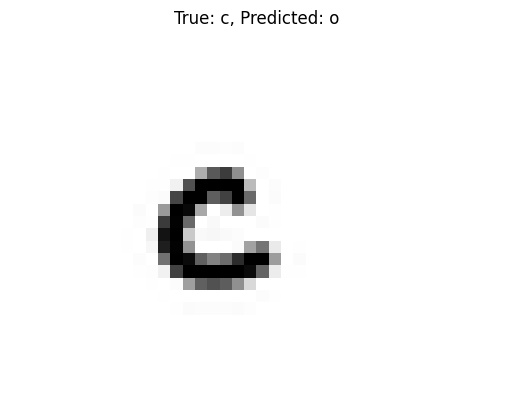

In [51]:
import matplotlib.pyplot as plt


# Pick a test sample index that was misclassified
index = 100  # Change this to check different test images

# Reshape the image correctly
image = test_X[:, index].reshape((img_height, img_width))  # Shape should match the resized image

# Get true label and predicted label
true_label = test_Y_labels[index]  
predicted_label = predict(W, b, test_X[:, index].reshape(-1, 1))[0]  # Predict on single sample

# Reverse mapping from index to character label
index_to_label = {idx: label for label, idx in label_to_index.items()}
true_char = index_to_label[true_label]
predicted_char = index_to_label[predicted_label]

# Plot the misclassified image
plt.imshow(image, cmap="gray")
plt.title(f"True: {true_char}, Predicted: {predicted_char}")
plt.axis("off")
plt.show()